## Flamelet table with heat loss
- Table
    - $\phi(f, \gamma, X)$ 
        - $\phi$ is some variable, like $h$, $c$, $T$, $\rho$, etc.
        - $f$ is mixture fraction
        - $\gamma$ is heat loss
        - $X$ is a variable that maps to progress variable, stored as integer indices
    - These functions are `RGI` in the code below
- Inversion
    - Given $(f,\, h,\, c)$, find $(f,\, \gamma,\, X)$.
        - $f$ is known directly.
        - $f$, $h\rightarrow\gamma = (h_a(f)-h)/h_{\rm sens}(f)$
        - 1-D inversion to find $X$ corresponding to $c$ for given $f$, $\gamma$
- For $f$ close to 0 or 1, both $h_{\rm sens}\rightarrow 0$ and $\gamma\rightarrow 0$. For these $f$, avoid division by $h_{\rm sens}=0$ by taking $\gamma=0$ directly.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from scipy.interpolate import interp1d
from scipy.interpolate import RegularGridInterpolator as RGI
from scipy.optimize import fsolve

In [ ]:
nf = 102           # number of mixture fractions
nγ = 13            # number of heat loss values
nX= 24             # number of "chi" values (chi and unsteady times that map to c)

fgrid = np.linspace(0,1,nf)              # table coordinates in f; differs here from table (spacing for 1st and last points)
γgrid = np.linspace(0.0,0.6,nγ)          # table coordinates in γ
Xgrid = np.arange(nX, dtype=np.float64)  # parametric, integer values

h = np.zeros((nf, nγ, nX))     # enthalpy (J/kg)
c = np.zeros((nf, nγ, nX))     # progress variable (y_H2 + y_H2O + y_CO + y_CO2
T = np.zeros((nf, nγ, nX))     # temperature
#---- fill in others here

#####################################################
# Fill in variable arrays, interpolate to given fgrid

for iX in range(nX):
    for iγ in range(nγ):
        fname = "flm_" + str(iX).zfill(2) + '_' + str(iγ).zfill(2) + ".dat"
        data = np.loadtxt(fname)

        ii = interp1d(data[:,1], data[:,3])       # mixf, h
        h[:, iγ, iX] = ii(fgrid)

        ii = interp1d(data[:,1], data[:,4])       # mixf, c
        c[:, iγ, iX] = ii(fgrid)

        ii = interp1d(data[:,1], data[:,2])       # mixf, T
        T[:, iγ, iX] = ii(fgrid)
        
#####################################################
# get sensible enthalpy and h0, h1 corresponding to f=0, f=1 streams

data = np.loadtxt('hsens.dat')
h0 = data[0,1]                        # 1st and last entries are h0, h1; interior are hsens
h1 = data[-1,1]
data[0,1]  = 0.0
data[-1,1] = 0.0
ii = interp1d(data[:,0], data[:,1])   # mixf, hsens 
hsens = ii(fgrid)

#####################################################
# get multilinear interpolation functions

hI = RGI((fgrid, γgrid, Xgrid), h, bounds_error=False, fill_value=None, method='linear')      
cI = RGI((fgrid, γgrid, Xgrid), c, bounds_error=False, fill_value=None, method='linear')      # call as cI([fvalue, Lvalue, tvalue])
TI = RGI((fgrid, γgrid, Xgrid), T, bounds_error=False, fill_value=None, method='linear')

hsI = interp1d(fgrid, hsens)  # 1D interpolator for hsens

#####################################################
# Inversion functions

def get_γ(f, h):
    ha = h0*(1.0-f) + h1*f
    γ = 0.0 if f<=0.00001 or f>=0.99999 else (ha-h)/hsI(f)
    return γ 

def get_X(f, h, c):
    γ = get_γ(f,h)
    X_guess = 0.0
    return fsolve(lambda X: cI([f, γ, X[0]])[0]-c, X_guess)[0]

In [78]:
odt = np.loadtxt('../data_radi/dmp_00012.dat')     # 9, 10, 11, 12
xodt = odt[:,0]
Todt = odt[:,7]
hodt = odt[:, 28]
codt = odt[:, 11] + odt[:,16] + odt[:,22] + odt[:,23]
fodt = odt[:,8]
fodt[fodt<0.0] = 0.0; fodt[fodt>1.0] = 1.0

nodt = len(fodt)
TT = np.zeros(nodt)
cc = np.zeros(nodt)
hh = np.zeros(nodt)
ibad = []
for i in range(nodt):
    γ = get_γ(fodt[i], hodt[i])
    X = get_X(fodt[i], hodt[i], codt[i])
    #if X < Xgrid[-1]: X = Xgrid[-1]
    #if X > Xgrid[0]:  X = Xgrid[0]
    TT[i] = TI([fodt[i], γ, X])[0]
    cc[i] = cI([fodt[i], γ, X])[0]
    hh[i] = hI([fodt[i], γ, X])[0]

    if γ < γgrid[0] or γ > γgrid[-1]: 
        print(f'γ = {γ} out of range')
        ibad.append(i)
    if X < Xgrid[0] or X > Xgrid[-1]: 
        cLo = cI([fodt[i], γ, -1])[0]
        cHi = cI([fodt[i], γ, 0])[0]
        Te = TI([fodt[i], γ, 0])[0] if X<Xgrid[0] else TI([fodt[i], γ, -1])[0]
        print(f'i={i}, f={fodt[i]:.5f}, γ={γ:.3f}, X={X}, codt={codt[i]:.5f}, cLo={cLo:.5f}, cHi={cHi:.5f}, TT={TT[i]:.1f}, Todt={Todt[i]:.1f}, Te={Te:.1f}')
        ibad.append(i)


/var/folders/_7/42qnnz6j17g26jhlhv2l5_580000gn/T/ipykernel_25487/1376727424.py:62: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  return fsolve(lambda X: cI([f, γ, X[0]])[0]-c, X_guess)[0]


i=18, f=0.00004, γ=0.461, X=-171559.72661973487, codt=0.00032, cLo=0.00021, cHi=0.00021, TT=302.9, Todt=302.3, Te=301.1
i=19, f=0.00014, γ=0.333, X=-98836.56818110327, codt=0.00082, cLo=0.00071, cHi=0.00071, TT=306.4, Todt=305.9, Te=304.5
i=20, f=0.00063, γ=0.296, X=-21568.439466349595, codt=0.00327, cLo=0.00316, cHi=0.00316, TT=323.0, Todt=323.1, Te=321.1
i=21, f=0.00204, γ=0.290, X=-7002.159902546911, codt=0.01030, cLo=0.01018, cHi=0.01018, TT=370.6, Todt=372.2, Te=368.6
i=22, f=0.00413, γ=0.292, X=-3791.247337612574, codt=0.02072, cLo=0.02060, cHi=0.02060, TT=440.7, Todt=443.3, Te=438.5
i=23, f=0.00567, γ=0.294, X=-2941.1879600215, codt=0.02843, cLo=0.02829, cHi=0.02829, TT=492.1, Todt=494.5, Te=489.8
i=24, f=0.00717, γ=0.297, X=-2468.973838859927, codt=0.03593, cLo=0.03578, cHi=0.03578, TT=541.6, Todt=543.1, Te=539.1
i=25, f=0.00889, γ=0.300, X=-2124.5338488230796, codt=0.04450, cLo=0.04435, cHi=0.04435, TT=597.7, Todt=597.2, Te=595.1
i=26, f=0.01058, γ=0.303, X=-1579.9420921434717

/var/folders/_7/42qnnz6j17g26jhlhv2l5_580000gn/T/ipykernel_25487/1376727424.py:62: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last five Jacobian evaluations.
  return fsolve(lambda X: cI([f, γ, X[0]])[0]-c, X_guess)[0]


i=763, f=0.02535, γ=0.177, X=-6.399583797641736, codt=0.12648, cLo=0.12646, cHi=0.12646, TT=1195.2, Todt=1196.6, Te=1194.9
i=764, f=0.02363, γ=0.176, X=-13.076261245755692, codt=0.11794, cLo=0.11791, cHi=0.11791, TT=1143.0, Todt=1144.5, Te=1142.6
i=765, f=0.02163, γ=0.176, X=-23.24918460421371, codt=0.10793, cLo=0.10789, cHi=0.10789, TT=1081.7, Todt=1082.2, Te=1081.2
i=766, f=0.02035, γ=0.176, X=-47.59444765734193, codt=0.10158, cLo=0.10153, cHi=0.10153, TT=1042.4, Todt=1041.6, Te=1041.7
i=767, f=0.02165, γ=0.178, X=-55.747063654966695, codt=0.10811, cLo=0.10803, cHi=0.10803, TT=1081.2, Todt=1081.6, Te=1079.9
i=768, f=0.02300, γ=0.180, X=-53.548285803042994, codt=0.11483, cLo=0.11473, cHi=0.11473, TT=1121.1, Todt=1122.4, Te=1119.6
i=769, f=0.02428, γ=0.181, X=-50.28515949186594, codt=0.12125, cLo=0.12113, cHi=0.12113, TT=1159.3, Todt=1160.8, Te=1157.6
i=770, f=0.02558, γ=0.183, X=-46.862702662623796, codt=0.12772, cLo=0.12760, cHi=0.12759, TT=1197.8, Todt=1199.1, Te=1195.9
i=771, f=0.0

## A-priori comparison to ODT

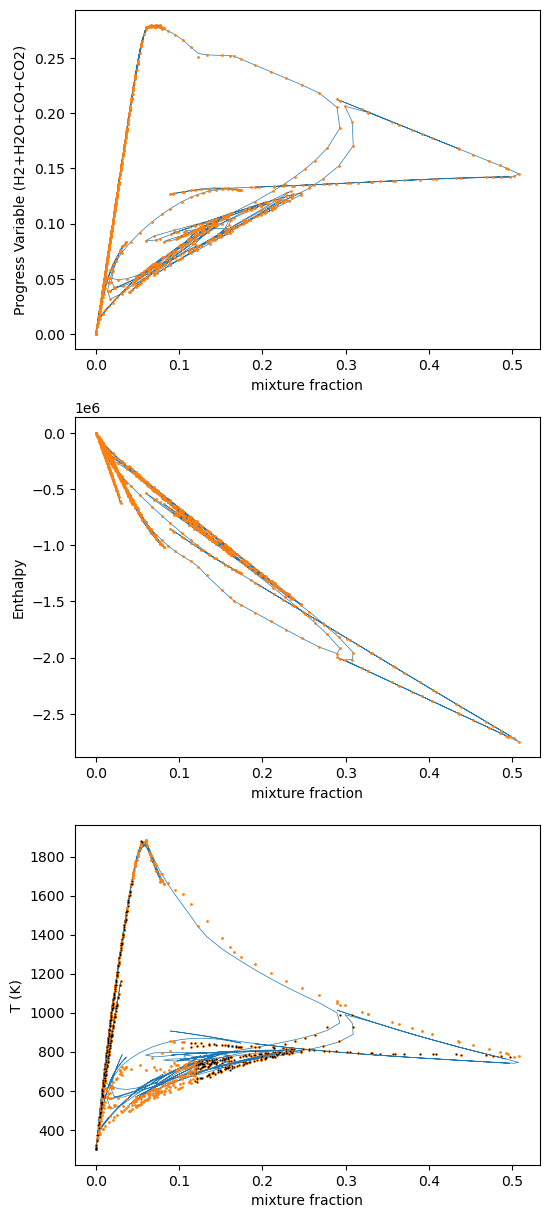

In [79]:
dof = True                   # true to plot vs mixture fraction, else position

plt.figure(figsize=(6,15))
plt.subplot(3,1,1)
plt.plot(fodt if dof else xodt, codt, '-', lw=0.5)
plt.plot(fodt if dof else xodt, cc, 'o', ms=1, lw=0.5)
if not dof: plt.xlim([-0.25,0.2])
if dof: 
    plt.xlabel('mixture fraction')
else:
    plt.xlabel('position')
plt.ylabel('Progress Variable (H2+H2O+CO+CO2)')

plt.subplot(3,1,2)
plt.plot(fodt if dof else xodt, hodt, '-', lw=0.5)
plt.plot(fodt if dof else xodt, hh, 'o', ms=1, lw=0.5)
if not dof: plt.xlim([-0.25,0.2])
if dof: 
    plt.xlabel('mixture fraction')
else:
    plt.xlabel('position')
plt.ylabel('Enthalpy')

plt.subplot(3,1,3)
plt.plot(fodt if dof else xodt, Todt, '-', lw=0.5)
plt.plot(fodt if dof else xodt, TT, 'o', ms=1, lw=0.5)
plt.plot(fodt[ibad] if dof else xodt[ibad], TT[ibad], 'x', ms=0.5, color='black')
if not dof: plt.xlim([-0.25,0.2])
#plt.ylim([100,2300])
if dof: 
    plt.xlabel('mixture fraction')
else:
    plt.xlabel('position')
plt.ylabel('T (K)')
plt.savefig('t2_position.pdf')